# [3주차] 심화과제 - Pre-trained 모델로 효율적인 NLP 모델 학습하기

-

In [1]:
%pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

### 1. 데이터셋 준비

Kaggle 데이터셋을 다운로드 받는다.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/unlocking-language-understanding-with-the-multin


kaggle 데이터셋은 다음과 같이 구성되어 있다.
- premise: 기준이 되는 첫 번째 문장
- hypothesis: 두 번째 문장
- label: 두 문장의 관계
  - entailment: 논리적 연결(0)
  - contradiction: 모순 관계(1)
  - neutral: 무관한 관계(2)

In [3]:
import random
import pandas as pd

def load_data(path, nrows=None):
  df = pd.read_csv(path, nrows=nrows, keep_default_na=False)
  data = []
  for _, row in df.iterrows():
    if len(row['premise']) * len(row['hypothesis']) != 0:
      data.append({'premise': row['premise'], 'hypothesis': row['hypothesis'], 'label': row['label']})

  return data

train_data = load_data(path+'/train.csv', nrows=5000)
test_data = load_data(path+'/validation_matched.csv', nrows=5000)

print("\n=== 데이터 예시 ===")
print("첫 번째 예시:")
print(f"Premise: {train_data[0]['premise']}")
print(f"Hypothesis: {train_data[0]['hypothesis']}")
print(f"Label: {train_data[0]['label']}")

print("\n두 번째 예시:")
print(f"Premise: {train_data[1]['premise']}")
print(f"Hypothesis: {train_data[1]['hypothesis']}")
print(f"Label: {train_data[1]['label']}")


=== 데이터 예시 ===
첫 번째 예시:
Premise: Conceptually cream skimming has two basic dimensions - product and geography.
Hypothesis: Product and geography are what make cream skimming work. 
Label: 1

두 번째 예시:
Premise: you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him
Hypothesis: You lose the things to the following level if the people recall.
Label: 0


RoBERTa 토크나이저를 불러온다.

In [4]:
from transformers import RobertaTokenizer

# RoBERTa 토크나이저 로드
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')  # 또는 'roberta-large'

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [5]:
from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader


def collate_fn(batch):
    premises, hypotheses, labels = [], [], []

    # 배치 내 각 샘플에서 premise, hypothesis, label 추출
    for row in batch:
        premises.append(row['premise'])
        hypotheses.append(row['hypothesis'])
        labels.append(row['label'])

    # tokenizer로 두 문장을 함께 토큰화
    encoded = tokenizer(
        premises,
        hypotheses,
        padding=True,
        truncation='longest_first',
        max_length=156,
        return_tensors='pt',
        add_special_tokens=True  # RoBERTa의 special 토큰 추가
    )

    # label을 텐서로 변환한다
    labels = torch.LongTensor(labels)

    # 모델 입력에 필요한 모든 정보 반환
    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask'],
        'labels': labels
    }

batch_size = 32

# DataLoader 설정
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

# 데이터 형태 확인
for batch in train_loader:
    print("배치 크기:", batch['input_ids'].shape)
    print("어텐션 마스크 크기:", batch['attention_mask'].shape)
    print("라벨 크기:", batch['labels'].shape)
    print("\n첫 번째 배치 예시:")
    print("입력 ID:", batch['input_ids'][0])
    print("라벨:", batch['labels'][0])
    break

배치 크기: torch.Size([32, 80])
어텐션 마스크 크기: torch.Size([32, 80])
라벨 크기: torch.Size([32])

첫 번째 배치 예시:
입력 ID: tensor([    0, 20981, 33195,    24,    16,  2778,  5544,     6,    19,    10,
         1353, 24456,     9,   239,  9787,     8, 14798, 14165,   196,    19,
        10602,  1895,    12, 28236,     4,     2,     2, 34383,     6,     5,
          317,    16,    45,   269,  5544,    23,    70,     4,  4041,  9787,
            4,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])
라벨: tensor(2)


### 2. 모델 정의

MNLI task를 위해 시퀀스 분류용 모델 RobertaForSequenceClassification을 불러온다.

In [6]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',  # 또는 'roberta-large'
    num_labels=3,    # entailment, contradiction, neutral
    problem_type="single_label_classification", # 하나의 레이블만 선택
    classifier_dropout=0.3, # 분류기(classifier) 레이어의 dropout 비율
    attention_probs_dropout_prob=0.1,  # 어텐션 스코어에 적용되는 dropout 비율
    hidden_dropout_prob=0.1 # 트랜스포머 hidden states의 dropout 비율
)

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델의 입력과 출력, 예측 결과 형태를 확인한다.

In [7]:
# 예시 데이터
premise = "Conceptually cream skimming has two basic dimensions - product and geography."
hypothesis = "Product and geography are what make cream skimming work."

# 입력 형태
encoded = tokenizer(
    premise,
    hypothesis,
    padding=True,
    truncation=True,
    max_length=124,
    return_tensors='pt'
)
encoded = {k: v.to(device) for k, v in encoded.items()}

print("=== 입력 형태 ===")
print("input_ids 형태:", encoded['input_ids'].shape)
print("attention_mask 형태:", encoded['attention_mask'].shape)

# 모델 출력
outputs = model(**encoded)
print("\n=== 출력 형태 ===")
print("로짓 형태:", outputs.logits.shape)  # [batch_size, 3] - 3개 클래스에 대한 점수

# 예측 클래스
predicted_class = torch.argmax(outputs.logits, dim=1)
print("\n=== 예측 결과 ===")
print("예측 클래스:", predicted_class.item())  # 0: entailment, 1: contradiction, 2: neutral

# 레이블과 예측값 매핑
label_map = {0: 'entailment', 1: 'contradiction', 2: 'neutral'}
print("예측 결과:", label_map[predicted_class.item()])

=== 입력 형태 ===
input_ids 형태: torch.Size([1, 30])
attention_mask 형태: torch.Size([1, 30])

=== 출력 형태 ===
로짓 형태: torch.Size([1, 3])

=== 예측 결과 ===
예측 클래스: 1
예측 결과: contradiction


fine tuning 전/후를 비교하기 위해 정확도를 계산하고 모델의 성능을 평가하는 함수를 추가한다.

In [8]:
# 정확도 계산 함수
def compute_accuracy(model, data_loader, print_errors=False):
    model.eval()
    correct = 0
    total = 0

    # 오답 사례를 저장할 리스트
    error_cases = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)

            # 오답 케이스 찾기
            if print_errors:
                incorrect_indices = (predictions != labels).nonzero(as_tuple=True)[0]
                for idx in incorrect_indices:
                    # batch에서 원본 데이터 가져오기
                    original_premise = data_loader.dataset[batch_size * batch_idx + idx]['premise']
                    original_hypothesis = data_loader.dataset[batch_size * batch_idx + idx]['hypothesis']

                    error_cases.append({
                        'premise': original_premise,
                        'hypothesis': original_hypothesis,
                        'predicted': predictions[idx].item(),
                        'actual': labels[idx].item()
                    })

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    # 오답 사례 출력
    if print_errors and error_cases:
        print("\n=== 예측 실패 사례 ===")
        label_map = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
        for i, case in enumerate(error_cases[:5]):  # 처음 5개만 출력
            print(f"\n사례 {i+1}:")
            print(f"Premise: {case['premise']}")
            print(f"Hypothesis: {case['hypothesis']}")
            print(f"예측: {label_map[case['predicted']]}")
            print(f"실제: {label_map[case['actual']]}")
            print("-" * 50)

    return correct / total

# 모델 성능 평가 함수
def evaluate(model, train_loader, test_loader, title_prefix=""):
    # 정확도 계산
    train_acc = compute_accuracy(model, train_loader, print_errors=False)
    test_acc = compute_accuracy(model, test_loader, print_errors=True)

    print(f"\n=== {title_prefix} 모델 성능 ===")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return train_acc, test_acc

overfitting을 방지하기 위해 early stopping을 정의한다.

In [9]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, max_train_acc=0.95, verbose=True):
        """
        patience: 성능 향상이 없어도 기다리는 에폭 수
        min_delta: 성능 향상으로 간주할 최소 변화량
        verbose: 상세 출력 여부
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.best_acc = None
        self.early_stop = False
        self.best_model = None
        self.max_train_acc = max_train_acc

    def __call__(self, val_loss, val_acc, train_acc, model):
        # 학습 정확도가 너무 높아지면 조기 종료
        if train_acc > self.max_train_acc:
            if self.verbose:
                print(f'Early stopping: Train accuracy ({train_acc:.4f}) exceeded threshold ({self.max_train_acc:.4f})')
            self.early_stop = True
            return

        if self.best_loss is None:  # 첫 에폭
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:  # 성능 향상이 없는 경우
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'Early stopping triggered! Best accuracy: {self.best_acc:.4f}')
        else:  # 성능이 향상된 경우
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.best_model = model.state_dict()
            self.counter = 0

### 3. Fine tuning

#### 1) freeze 하지 않은 경우

학습 함수를 정의한다.

overfitting을 방지하기 위해 early stop을 추가하고 epochs를 넉넉하게 설정하였다.

In [10]:
import torch
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup

# 학습 함수
def train_model(model, train_loader, test_loader):
    model = model.to(device)

    lr = 5e-6
    n_epochs = 50

    # AdamW 옵티마이저 사용 (트랜스포머 모델에 더 적합)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.1)

    # 웜업 스케줄러 추가
    num_training_steps = len(train_loader) * n_epochs
    # 처음 10%는 학습률을 천천히 증가시키고 그 후 선형적으로 감소
    num_warmup_steps = num_training_steps // 10
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    # Early Stopping 초기화
    early_stopping = EarlyStopping(
        patience=3,
        min_delta=0.001,
        max_train_acc=0.95,
        verbose=True
    )

    train_losses = []
    train_accs = []
    test_accs = []

    # 그라디언트 스케일러 추가
    # Mixed Precision 학습에서 발생할 수 있는 그라디언트 소실(gradient underflow)문제를 방지하기 위함
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{n_epochs}')

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            # 학습 속도 향상 및 메모리 사용량 감소 위해 Mixed precision 학습 적용
            with torch.cuda.amp.autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

            loss = outputs.loss
            total_loss += loss.item()

            # 그라디언트 스케일링 적용
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # 학습률 스케줄러 업데이트
            scheduler.step()

            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 에폭마다 정확도 계산
        train_acc = compute_accuracy(model, train_loader)
        test_acc = compute_accuracy(model, test_loader)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"\nEpoch {epoch + 1}/{n_epochs}")
        print(f"Total Loss: {total_loss:.4f}")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}\n")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.2e}\n")

        # Early Stopping 체크
        early_stopping(avg_loss, test_acc, train_acc, model)
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}")
            # 최고 성능 모델로 복원
            model.load_state_dict(early_stopping.best_model)
            break

    return train_losses, train_accs, test_accs

fine tuning 전/후 성능을 측정한다.

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


=== 예측 실패 사례 ===

사례 1:
Premise: The new rights are nice enough
Hypothesis: Everyone really likes the newest benefits 
예측: entailment
실제: neutral
--------------------------------------------------

사례 2:
Premise: This site includes a list of all award winners and a searchable database of Government Executive articles.
Hypothesis: The Government Executive articles housed on the website are not able to be searched.
예측: entailment
실제: contradiction
--------------------------------------------------

사례 3:
Premise: uh i don't know i i have mixed emotions about him uh sometimes i like him but at the same times i love to see somebody beat him
Hypothesis: I like him for the most part, but would still enjoy seeing someone beat him.
예측: neutral
실제: entailment
--------------------------------------------------

사례 4:
Premise: yeah i i think my favorite restaurant is always been the one closest  you know the closest as long as it's it meets the minimum criteria you know of good food
Hypothesis: 

Epoch 1/50:   0%|          | 0/157 [00:00<?, ?it/s]<ipython-input-10-7113f9bd998d>:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 157/157 [00:29<00:00,  5.40it/s, loss=1.1]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be awa


Epoch 1/50
Total Loss: 173.6187
Average Loss: 1.1059
Train Accuracy: 0.3398
Test Accuracy: 0.3506

Learning Rate: 1.00e-06



Epoch 2/50: 100%|██████████| 157/157 [00:27<00:00,  5.81it/s, loss=1.09]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing t


Epoch 2/50
Total Loss: 172.6665
Average Loss: 1.0998
Train Accuracy: 0.3888
Test Accuracy: 0.3494

Learning Rate: 2.00e-06



Epoch 3/50: 100%|██████████| 157/157 [00:26<00:00,  5.91it/s, loss=0.957]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing 


Epoch 3/50
Total Loss: 170.7735
Average Loss: 1.0877
Train Accuracy: 0.5166
Test Accuracy: 0.4674

Learning Rate: 3.00e-06



Epoch 4/50: 100%|██████████| 157/157 [00:26<00:00,  5.97it/s, loss=0.429]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing 


Epoch 4/50
Total Loss: 130.3342
Average Loss: 0.8302
Train Accuracy: 0.7836
Test Accuracy: 0.7244

Learning Rate: 4.00e-06



Epoch 5/50:  44%|████▍     | 69/157 [00:11<00:14,  5.87it/s, loss=0.74]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 5/50: 100%|██████████| 157/157 [00:26<00:00,  5.93it/s, loss=0.649]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always


Epoch 5/50
Total Loss: 88.8551
Average Loss: 0.5660
Train Accuracy: 0.8778
Test Accuracy: 0.7676

Learning Rate: 5.00e-06



Epoch 6/50: 100%|██████████| 157/157 [00:26<00:00,  5.95it/s, loss=0.285]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing 


Epoch 6/50
Total Loss: 65.9830
Average Loss: 0.4203
Train Accuracy: 0.9202
Test Accuracy: 0.7722

Learning Rate: 4.89e-06



Epoch 7/50: 100%|██████████| 157/157 [00:26<00:00,  5.96it/s, loss=0.22]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing t


Epoch 7/50
Total Loss: 52.1695
Average Loss: 0.3323
Train Accuracy: 0.9394
Test Accuracy: 0.7684

Learning Rate: 4.78e-06



Epoch 8/50: 100%|██████████| 157/157 [00:26<00:00,  5.91it/s, loss=0.4]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing to


Epoch 8/50
Total Loss: 39.9788
Average Loss: 0.2546
Train Accuracy: 0.9660
Test Accuracy: 0.7838

Learning Rate: 4.67e-06

Early stopping: Train accuracy (0.9660) exceeded threshold (0.9500)

Early stopping triggered at epoch 8


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


=== 예측 실패 사례 ===

사례 1:
Premise: The most important directions are simply up and up leads eventually to the cathedral and fortress commanding the hilltop, and down inevitably leads to one of three gates through the wall to the new town.
Hypothesis: Go downwards to one of the gates, all of which will lead you into the cathedral.
예측: entailment
실제: contradiction
--------------------------------------------------

사례 2:
Premise: see now in a situation like that the boys are only sixteen years old and they were sexually involved with her and i think like at that particular point she was twenty three you know so she wasn't really that much older than them and being a boy at that age i think that they're very um you know let's face it that's at a point in your life when you you're just starting to realize all the things of life
Hypothesis: Everyone involved was the same age.
예측: neutral
실제: contradiction
--------------------------------------------------

사례 3:
Premise: um-hum um-hum yeah w

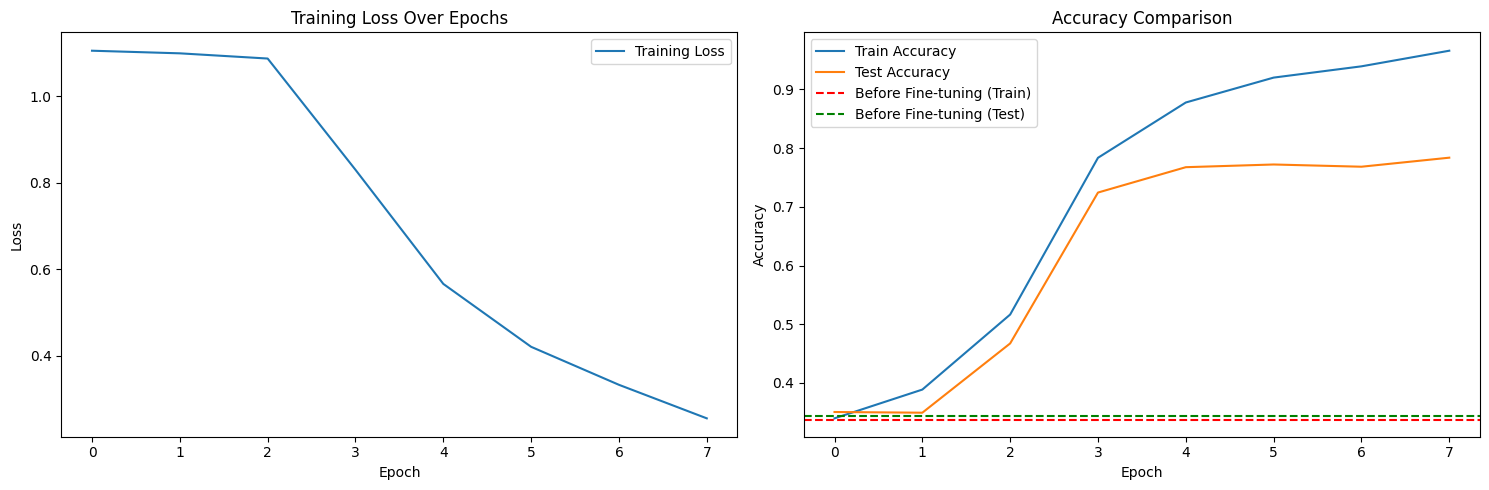


=== 성능 향상 분석 ===
Train Accuracy 향상: 62.98%
Test Accuracy 향상: 44.00%


In [11]:
# 1. Fine-tuning 전 성능 평가
before_train_acc, before_test_acc = evaluate(
    model, train_loader, test_loader, "Fine-tuning 전"
)

# 2. Fine-tuning 수행
print("\n=== Fine-tuning 시작 ===")

train_losses, train_accs, test_accs = train_model(
    model, train_loader, test_loader
)

# 3. Fine-tuning 후 성능 평가
after_train_acc, after_test_acc = evaluate(
    model, train_loader, test_loader, "Fine-tuning 후"
)

# 4. 결과 시각화
plt.figure(figsize=(15, 5))

# 학습 중 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.axhline(y=before_train_acc, color='r', linestyle='--', label='Before Fine-tuning (Train)')
plt.axhline(y=before_test_acc, color='g', linestyle='--', label='Before Fine-tuning (Test)')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 성능 향상 출력
print("\n=== 성능 향상 분석 ===")
print(f"Train Accuracy 향상: {(after_train_acc - before_train_acc)*100:.2f}%")
print(f"Test Accuracy 향상: {(after_test_acc - before_test_acc)*100:.2f}%")

#### 2) gradual unfreeze

In [14]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',  # 또는 'roberta-large'
    num_labels=3,    # entailment, contradiction, neutral
    problem_type="single_label_classification", # 하나의 레이블만 선택
    classifier_dropout=0.3, # 분류기(classifier) 레이어의 dropout 비율
    attention_probs_dropout_prob=0.1,  # 어텐션 스코어에 적용되는 dropout 비율
    hidden_dropout_prob=0.1 # 트랜스포머 hidden states의 dropout 비율
)

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def train_model_with_gradual_unfreeze(model, train_loader, test_loader):
    model = model.to(device)

    lr = 5e-6
    n_epochs = 50

    # 처음에 모든 레이어를 freeze
    for param in model.parameters():
        param.requires_grad = False

    # 분류기는 항상 학습 가능하게
    for param in model.classifier.parameters():
        param.requires_grad = True

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.1)

    # 웜업 스케줄러 설정
    num_training_steps = len(train_loader) * n_epochs
    num_warmup_steps = num_training_steps // 10
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    early_stopping = EarlyStopping(
        patience=3,
        min_delta=0.001,
        max_train_acc=0.95,
        verbose=True
    )

    train_losses = []
    train_accs = []
    test_accs = []

    scaler = torch.cuda.amp.GradScaler()

    # Gradual Unfreeze를 위한 레이어 설정
    # 전체 레이어 수
    num_layers = len(model.roberta.encoder.layer)
    unfreeze_per_epoch = num_layers // 4  # 4단계로 나누어 언프리즈

    for epoch in range(n_epochs):
        # Gradual Unfreeze
        if epoch % 5 == 0 and epoch > 0:  # 5 에폭마다, 단 0 에폭은 제외
            # 언프리즈 시작할 레이어 인덱스 계산
            layer_start = max(0, num_layers - (epoch // 5) * unfreeze_per_epoch)
            print(f"\n=== Unfreezing layers from {layer_start} to {num_layers} ===")
            for i in range(layer_start, num_layers):
                for param in model.roberta.encoder.layer[i].parameters():
                    param.requires_grad = True

            # 새로운 레이어가 언프리즈될 때마다 옵티마이저 재설정
            # 1. 새로 언프리즈된 레이어의 파라미터들이 옵티마이저에 포함되어야 함
            # 2. 이전 옵티마이저는 frozen 레이어를 제외하고 있었음
            # 3. 모멘텀과 같은 옵티마이저의 상태를 새로운 파라미터들에 대해 초기화
            optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=0.1)

            # 스케줄러 재설정
            # 1. 새로운 옵티마이저에 대한 새로운 스케줄링 필요
            # 2. 새로 언프리즈된 레이어들이 처음에는 낮은 학습률로 시작하도록 함
            # 3. 웜업을 통해 새 레이어들이 점진적으로 학습에 적응하도록 함
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=num_warmup_steps,
                num_training_steps=num_training_steps
            )

        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{n_epochs}')

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

            loss = outputs.loss
            total_loss += loss.item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            scheduler.step()

            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        train_acc = compute_accuracy(model, train_loader)
        test_acc = compute_accuracy(model, test_loader)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"\nEpoch {epoch + 1}/{n_epochs}")
        print(f"Total Loss: {total_loss:.4f}")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}\n")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.2e}\n")

        early_stopping(avg_loss, test_acc, train_acc, model)
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}")
            model.load_state_dict(early_stopping.best_model)
            break

    return train_losses, train_accs, test_accs


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


=== 예측 실패 사례 ===

사례 1:
Premise: The new rights are nice enough
Hypothesis: Everyone really likes the newest benefits 
예측: entailment
실제: neutral
--------------------------------------------------

사례 2:
Premise: This site includes a list of all award winners and a searchable database of Government Executive articles.
Hypothesis: The Government Executive articles housed on the website are not able to be searched.
예측: entailment
실제: contradiction
--------------------------------------------------

사례 3:
Premise: yeah i i think my favorite restaurant is always been the one closest  you know the closest as long as it's it meets the minimum criteria you know of good food
Hypothesis: My favorite restaurants are always at least a hundred miles away from my house. 
예측: entailment
실제: contradiction
--------------------------------------------------

사례 4:
Premise: i don't know um do you do a lot of camping
Hypothesis: I know exactly.
예측: entailment
실제: contradiction
--------------------------

Epoch 1/50:   0%|          | 0/157 [00:00<?, ?it/s]<ipython-input-15-bdb018eb8e8b>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50:  12%|█▏        | 19/157 [00:00<00:07, 18.60it/s, loss=1.12]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1/50: 100%|██████████| 157/157 [00:08<00:00, 19.19it/s, loss=1.01]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned


Epoch 1/50
Total Loss: 172.8686
Average Loss: 1.1011
Train Accuracy: 0.3394
Test Accuracy: 0.3506

Learning Rate: 1.00e-06



Epoch 2/50: 100%|██████████| 157/157 [00:07<00:00, 19.74it/s, loss=1.07]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing t


Epoch 2/50
Total Loss: 172.6233
Average Loss: 1.0995
Train Accuracy: 0.3408
Test Accuracy: 0.3510

Learning Rate: 2.00e-06



Epoch 3/50: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s, loss=1.06]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing t


Epoch 3/50
Total Loss: 172.4840
Average Loss: 1.0986
Train Accuracy: 0.3756
Test Accuracy: 0.3548

Learning Rate: 3.00e-06

EarlyStopping counter: 1 out of 3


Epoch 4/50: 100%|██████████| 157/157 [00:08<00:00, 19.02it/s, loss=1.04]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing t


Epoch 4/50
Total Loss: 172.5483
Average Loss: 1.0990
Train Accuracy: 0.3764
Test Accuracy: 0.3426

Learning Rate: 4.00e-06

EarlyStopping counter: 2 out of 3


Epoch 5/50: 100%|██████████| 157/157 [00:08<00:00, 19.18it/s, loss=1.05]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing t


Epoch 5/50
Total Loss: 172.4264
Average Loss: 1.0983
Train Accuracy: 0.3752
Test Accuracy: 0.3410

Learning Rate: 5.00e-06


=== Unfreezing layers from 9 to 12 ===


Epoch 6/50: 100%|██████████| 157/157 [00:11<00:00, 13.09it/s, loss=1.09]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing t


Epoch 6/50
Total Loss: 172.1611
Average Loss: 1.0966
Train Accuracy: 0.3722
Test Accuracy: 0.3352

Learning Rate: 1.00e-06



Epoch 7/50: 100%|██████████| 157/157 [00:11<00:00, 13.28it/s, loss=1.05]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing t


Epoch 7/50
Total Loss: 172.5100
Average Loss: 1.0988
Train Accuracy: 0.3720
Test Accuracy: 0.3344

Learning Rate: 2.00e-06

EarlyStopping counter: 1 out of 3


Epoch 8/50: 100%|██████████| 157/157 [00:11<00:00, 13.31it/s, loss=1.19]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing t


Epoch 8/50
Total Loss: 172.2410
Average Loss: 1.0971
Train Accuracy: 0.3720
Test Accuracy: 0.3344

Learning Rate: 3.00e-06

EarlyStopping counter: 2 out of 3


Epoch 9/50: 100%|██████████| 157/157 [00:11<00:00, 13.32it/s, loss=1.12]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing t


Epoch 9/50
Total Loss: 171.9641
Average Loss: 1.0953
Train Accuracy: 0.3720
Test Accuracy: 0.3346

Learning Rate: 4.00e-06



Epoch 10/50: 100%|██████████| 157/157 [00:11<00:00, 13.20it/s, loss=1.08]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing 


Epoch 10/50
Total Loss: 171.3179
Average Loss: 1.0912
Train Accuracy: 0.3754
Test Accuracy: 0.3370

Learning Rate: 5.00e-06


=== Unfreezing layers from 6 to 12 ===


Epoch 11/50: 100%|██████████| 157/157 [00:15<00:00,  9.89it/s, loss=1.1]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing t


Epoch 11/50
Total Loss: 170.2997
Average Loss: 1.0847
Train Accuracy: 0.4238
Test Accuracy: 0.3860

Learning Rate: 1.00e-06



Epoch 12/50: 100%|██████████| 157/157 [00:15<00:00,  9.93it/s, loss=1.08]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing 


Epoch 12/50
Total Loss: 166.8376
Average Loss: 1.0627
Train Accuracy: 0.5386
Test Accuracy: 0.5126

Learning Rate: 2.00e-06



Epoch 13/50: 100%|██████████| 157/157 [00:15<00:00,  9.95it/s, loss=1.13]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing 


Epoch 13/50
Total Loss: 144.6051
Average Loss: 0.9211
Train Accuracy: 0.6672
Test Accuracy: 0.6310

Learning Rate: 3.00e-06



Epoch 14/50: 100%|██████████| 157/157 [00:15<00:00,  9.82it/s, loss=0.606]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing


Epoch 14/50
Total Loss: 121.9964
Average Loss: 0.7770
Train Accuracy: 0.7316
Test Accuracy: 0.6780

Learning Rate: 4.00e-06



Epoch 15/50: 100%|██████████| 157/157 [00:15<00:00,  9.86it/s, loss=0.538]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing


Epoch 15/50
Total Loss: 106.3927
Average Loss: 0.6777
Train Accuracy: 0.7712
Test Accuracy: 0.7046

Learning Rate: 5.00e-06


=== Unfreezing layers from 3 to 12 ===


Epoch 16/50: 100%|██████████| 157/157 [00:20<00:00,  7.81it/s, loss=0.654]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing


Epoch 16/50
Total Loss: 96.3870
Average Loss: 0.6139
Train Accuracy: 0.7792
Test Accuracy: 0.7134

Learning Rate: 1.00e-06



Epoch 17/50: 100%|██████████| 157/157 [00:20<00:00,  7.77it/s, loss=0.917]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing


Epoch 17/50
Total Loss: 92.7782
Average Loss: 0.5909
Train Accuracy: 0.8046
Test Accuracy: 0.7314

Learning Rate: 2.00e-06



Epoch 18/50: 100%|██████████| 157/157 [00:19<00:00,  7.86it/s, loss=0.193]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing


Epoch 18/50
Total Loss: 85.4639
Average Loss: 0.5444
Train Accuracy: 0.8392
Test Accuracy: 0.7540

Learning Rate: 3.00e-06



Epoch 19/50: 100%|██████████| 157/157 [00:20<00:00,  7.79it/s, loss=0.701]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing


Epoch 19/50
Total Loss: 79.6811
Average Loss: 0.5075
Train Accuracy: 0.8710
Test Accuracy: 0.7616

Learning Rate: 4.00e-06



Epoch 20/50: 100%|██████████| 157/157 [00:20<00:00,  7.69it/s, loss=0.478]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing


Epoch 20/50
Total Loss: 71.0465
Average Loss: 0.4525
Train Accuracy: 0.9004
Test Accuracy: 0.7744

Learning Rate: 5.00e-06


=== Unfreezing layers from 0 to 12 ===


Epoch 21/50: 100%|██████████| 157/157 [00:24<00:00,  6.49it/s, loss=0.0958]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowin


Epoch 21/50
Total Loss: 59.4491
Average Loss: 0.3787
Train Accuracy: 0.9034
Test Accuracy: 0.7708

Learning Rate: 1.00e-06



Epoch 22/50: 100%|██████████| 157/157 [00:24<00:00,  6.50it/s, loss=0.103]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing


Epoch 22/50
Total Loss: 55.9145
Average Loss: 0.3561
Train Accuracy: 0.9188
Test Accuracy: 0.7708

Learning Rate: 2.00e-06



Epoch 23/50: 100%|██████████| 157/157 [00:24<00:00,  6.53it/s, loss=0.246]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing


Epoch 23/50
Total Loss: 53.2613
Average Loss: 0.3392
Train Accuracy: 0.9282
Test Accuracy: 0.7728

Learning Rate: 3.00e-06



Epoch 24/50: 100%|██████████| 157/157 [00:24<00:00,  6.45it/s, loss=0.0652]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowin


Epoch 24/50
Total Loss: 49.0827
Average Loss: 0.3126
Train Accuracy: 0.9538
Test Accuracy: 0.7760

Learning Rate: 4.00e-06

Early stopping: Train accuracy (0.9538) exceeded threshold (0.9500)

Early stopping triggered at epoch 24


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


=== 예측 실패 사례 ===

사례 1:
Premise: If that investor were willing to pay extra for the security of limited downside, she could buy put options with a strike price of $98, which would lock in her profit on the shares at $18, less whatever the options cost.
Hypothesis: THe strike price could be $8.
예측: neutral
실제: contradiction
--------------------------------------------------

사례 2:
Premise: see now in a situation like that the boys are only sixteen years old and they were sexually involved with her and i think like at that particular point she was twenty three you know so she wasn't really that much older than them and being a boy at that age i think that they're very um you know let's face it that's at a point in your life when you you're just starting to realize all the things of life
Hypothesis: Everyone involved was the same age.
예측: neutral
실제: contradiction
--------------------------------------------------

사례 3:
Premise: um-hum um-hum yeah well uh i can see you know it's it's it

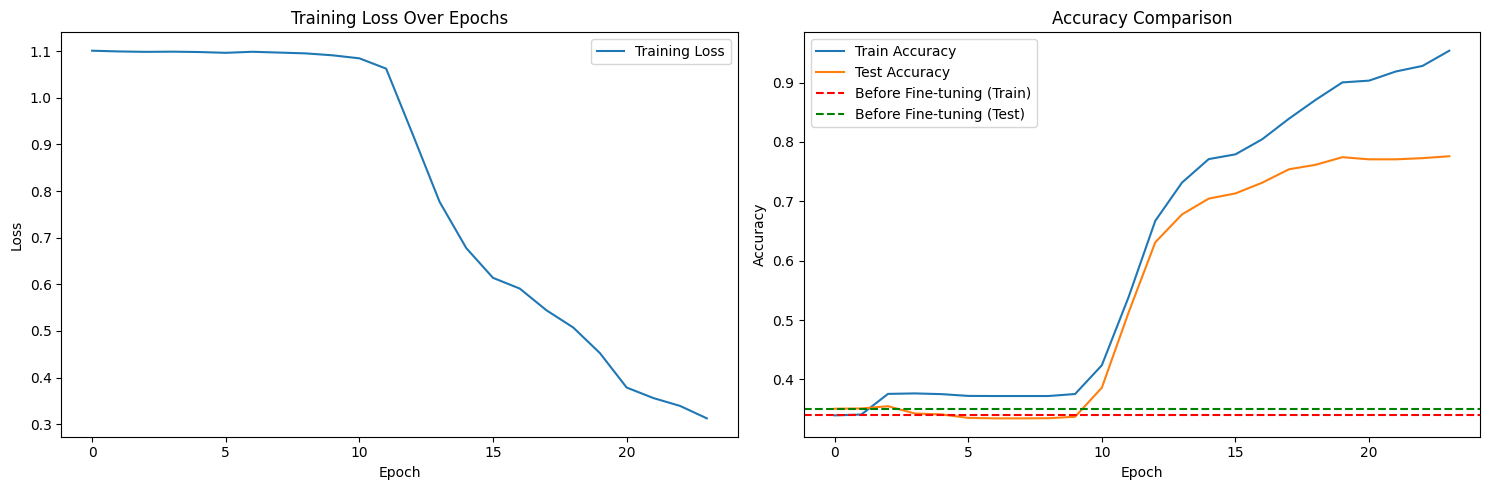


=== 성능 향상 분석 ===
Train Accuracy 향상: 61.42%
Test Accuracy 향상: 42.56%


In [16]:
# 1. Fine-tuning 전 성능 평가
before_train_acc, before_test_acc = evaluate(
    model, train_loader, test_loader, "Fine-tuning 전"
)

# 2. Fine-tuning 수행
print("\n=== Fine-tuning 시작 ===")

train_losses, train_accs, test_accs = train_model_with_gradual_unfreeze(
    model, train_loader, test_loader
)

# 3. Fine-tuning 후 성능 평가
after_train_acc, after_test_acc = evaluate(
    model, train_loader, test_loader, "Fine-tuning 후"
)

# 4. 결과 시각화
plt.figure(figsize=(15, 5))

# 학습 중 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.axhline(y=before_train_acc, color='r', linestyle='--', label='Before Fine-tuning (Train)')
plt.axhline(y=before_test_acc, color='g', linestyle='--', label='Before Fine-tuning (Test)')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 성능 향상 출력
print("\n=== 성능 향상 분석 ===")
print(f"Train Accuracy 향상: {(after_train_acc - before_train_acc)*100:.2f}%")
print(f"Test Accuracy 향상: {(after_test_acc - before_test_acc)*100:.2f}%")
